# Class 3: Bayesian Statistics Applied to Network Inference

Goals of today's class:
1. Brief overview of Bayesian statistics in general
2. Introduce infering model parameters from network data (preparing for Stochastic Block Models next week)
3. Learn how to determine whether a network is likely to have come from a particular model
4. Learn to conduct network inference from observational data
__________

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
________

In [1]:
%load_ext jupyter_tikz

In [55]:
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
# pip install tqdm ipywidgets for the above progress bar

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

### What is Bayesian Statistics?

Statistical techniques can be broadly put in two categories:

* _Frequentist Statistics_ uses evidence to estimate a point value. Probabilities are interpreted as long run frequencies.

* _Bayesian Statistics_ uses evidence and a set of prior beliefs to produce a posterior distribution of potential point values. Probabilities are interpreted as subjective degrees of belief.

For a crude example, say we flip a coin many times. In frequentist statistics we say $p(heads) = \frac{number\ of\ heads}{number\ of\ flips}$, so if $p(heads) = 0.5$ then over many coin flips about half the flips should come out heads.

In Bayesian statistics we have a prior belief about the fairness of the coin, expressed as a distribution. A normal distribution centered at 0.5 means "I believe the coin is fair, but I wouldn't be so surprised if it was a _tiny_ bit biased towards heads or tails. As the bias increases, so does my surprise." 


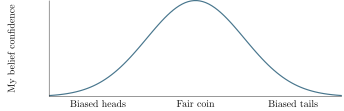

In [2]:
%%tikz -t=pgfplots
\pgfmathdeclarefunction{gauss}{3}{%
  \pgfmathparse{1/(#3*sqrt(2*pi))*exp(-((#1-#2)^2)/(2*#3^2))}%
}

\begin{tikzpicture}
\begin{axis}[
  no markers, 
  domain=0:6, 
  samples=100,
  ymin=0,
  axis lines*=left, 
  xlabel=$x$,
  every axis y label/.style={at=(current axis.above origin),anchor=south},
  every axis x label/.style={at=(current axis.right of origin),anchor=west},
  height=5cm, 
  width=12cm,
  xtick=\empty, 
  ytick=\empty,
  enlargelimits=false, 
  clip=false, 
  axis on top,
  grid = major,
  xlabel={},
  ylabel={My belief confidence},
  y label style={rotate=90,anchor=south,at={(axis description cs:-0.1,.5)}}
  ]

\addplot [very thick,cyan!50!black] {gauss(x, 3, 1)};
\node[below] at (axis cs:1, 0)  {Biased heads}; 
\node[below] at (axis cs:5, 0)  {Biased tails}; 
\node[below] at (axis cs:3, 0)  {Fair coin}; 
\end{axis}



\end{tikzpicture}

By contrast, a _uniform_ prior would indicate "I have no idea whether the coin is biased, I would believe all biases equally."

As we flip the coin we gather _evidence,_ and update our _posterior_ distribution, indicating our current belief about the coin's nature.

Given enough evidence, Bayesian and frequentist statistics will converge to the same answer. However, given limited evidence and an accurate prior, Bayesian techniques can converge more quickly. The Bayesian style of thinking is well-suited to network inference tasks, where we have a model, some prior beliefs about the parameters of that model, and gathered evidence about a network. 

____
### Bayes' Theorem

A foundation of Bayesian statistics is Bayes' theorem (Bae's theorem if you really love Bayesian stats) which allows us to take a formula for the probability of observations given a model configuration, and invert it to obtain the probability of a model configuration given our observations. The theorem is as follows:

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Or, in Bayesian language:

$$Posterior = \frac{Likelihood\ *\ Prior}{Marginalization}$$

I find this equation impenetrably dense without an example. Say we're in a windowless room and a student walks in with wet hair, and I want to know whether it's raining. I can say:

$$P(rain|hair) = \frac{P(hair|rain)P(rain)}{P(hair)}$$

That is, the probability that it's raining given that someone walked in with wet hair is based on:

1. The probability that they'd have wet hair if it were raining. Are they carrying an umbrella?
2. The probability that it's raining. If we are in a desert then there are likely better explanations.
3. The probability that the student's hair is wet. If their hair is _always_ wet (maybe they take a shower right before office hours) then this is not a useful signal.

_________
### Bayesian Statistics in Network Science

We use Bayesian statistics in two ways during network analysis:

1. Predicting model parameters given a network generated by the model
2. Predicting edges based on observations, given an underlying model

__________

#### Estimating p from a G(N,p) graph

Say we have an adjacency matrix $A$ that comes from an Erdos-Renyi graph. We want to estimate $p$. We'll start with the opposite problem: given an ER graph parameterized by $p$, what is the probability of generating adjacency matrix $A$?

**Your turn: what is the probability of generating a graph with $m$ edges in terms of $n$ and $p$?**

To start with, how many edges should we expect in an ER graph with $n$ nodes and $p$ edge probability?

We know the probability of a given graph is:

$$P(A|p) = \prod_{i<j} \begin{cases} p & A_{ij} \text{ (edge exists)} \\ 1-p & 1-A_{ij} \text{ (edge does not exist)}\end{cases}$$

Or more concisely:

$$P(A|p) = \prod_{i<j} p^{A_{ij}} (1-p)^{1 - A_{ij}} = l(p)$$

For convenience, let's re-paramaterize in terms of the size of the graph with $m$ edges and $n$ vertices:

$$l(p) = p^m (1-p)^{\binom{n}{2} - m}$$

That is, the likelihood of generating a graph is given by the probability of an edge for each edge that exists, times the probability of no edge for each edge does not exist.

Now, given a graph $A$, what is the most likely $p$? We want $\operatorname*{argmax}_p l(p)$. How do we solve for argmax? With partial derivatives and _maximum likelihood estimation (MLE)._

When $\frac{\partial}{\partial p} = 0$ we have an inflection point. Because this is a concave function that inflection point is guaranteed to be a global maximum.

**Useful fact:** $\operatorname*{argmax}_p l(p) = \operatorname*{argmax}_p \log(l(p))$. Why useful? Because in logs products become sums, which are much easier to differentiate. Additionally, our probabilities will often be very tiny, which presents numeric instability with floating point numbers. Logarithms will boost our probabilities into a higher range and stabilize calculations.

$$
\begin{align}
l(p) &= p^m (1-p)^{\binom{n}{2} - m} && \text{Given} \\
\log(l(p)) &= m \log p + \left[\binom{n}{2}-m\right] \log (1-p) && \text{Logarithm} \\
\frac{\partial}{\partial p} \log l(p) &= \frac{m}{p} + \frac{\binom{n}{2} - m}{1-p}(-1) = 0 && \text{Derive wrt p and set to zero to find max} \\
\frac{m}{p} - \frac{\binom{n}{2} - m}{1-p} &= 0 && \text{Simplify} \\
\frac{m}{p} &= \frac{\binom{n}{2} - m}{1-p} && \text{Simplify} \\
\frac{m}{\binom{n}{2} - m} &= \frac{p}{1-p} && \text{Cross multiply} \\
\frac{p}{1-p} &= \frac{m}{\binom{n}{2} - m} * \frac{\binom{n}{2}^{-1}}{\binom{n}{2}^{-1}} && \text{Multiply by useful identity} \\
\frac{p}{1-p} &= \frac{m / \binom{n}{2}}{1 - m/\binom{n}{2}} && \text{Simplify} \\
p &= \frac{m}{\binom{n}{2}} && \text{Only value of $p$ that makes this true}
\end{align}
$$

This matches our intuition: the edge probability is equal to the graph density, which is the percentage of possible edges that actually exist. We can solve from the definition of an ER graph and get to the same answer:

$G(n,p)$ means $p$ chance of any possible edge existing, and for $n$ nodes there are $m = \frac{n(n-1)}{2}$ possible edges, or $m = p \binom{n}{2}$, so $p = \frac{m}{\binom{n}{2}}$

### Your turn!

There are two mystery graphs with this notebook. Do they come from G(n,p)? Let's find out!

First, load the graphs. Assuming they come from G(n,p), estimate the most likely value of p.

In [9]:
G1 = nx.read_adjlist("data/mystery_adj_list1.txt")
G2 = nx.read_adjlist("data/mystery_adj_list2.txt")

def estimateP(G):
    # Your code here!
    pass

#print("The most likely p for G1 is %.4f" % estimateP(G1))
#print("The most likely p for G2 is %.4f" % estimateP(G2))

Next, generate some reference distributions of G(n,p) graphs, and compare several graph metrics.

In [10]:
def generateNetworks(n, p, c):
    networks = []
    for i in range(c):
        G = nx.gnp_random_graph(n,p)
        networks.append(G)
    return networks

In [ ]:
G1reference = generateNetworks(n1, p1, 100)
G2reference = generateNetworks(n2, p2, 100)

# Now calculate three kinds of statistics for each reference graph, and calculate the same statistic for G1 and G2

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10,6))
# Plot the statistics as distributions in a 2x3 plot (one row for G1, onr row for G2), with a reference line for G1 and G2
# Your code here...
plt.show()

#### Reference solution, do not look below

In [27]:
G1 = nx.read_adjlist("data/mystery_adj_list1.txt")
G2 = nx.read_adjlist("data/mystery_adj_list2.txt")

def estimateP(G):
    edges = G.number_of_edges()
    return edges / math.comb(G.number_of_nodes(), 2)

def generateNetworks(n, p, c):
    networks = []
    for i in tqdm(range(c), desc="Generating %d graphs" % c):
        G = nx.gnp_random_graph(n,p)
        networks.append(G)
    return networks

p1 = estimateP(G1)
ref1 = generateNetworks(G1.number_of_nodes(), p1, 100)
p2 = estimateP(G2)
ref2 = generateNetworks(G2.number_of_nodes(), p2, 100)

rows = []
for G in tqdm(ref1, desc="Calculating features for ref1"):
    t = nx.transitivity(G)
    a = nx.average_shortest_path_length(G)
    d = nx.degree_assortativity_coefficient(G)
    rows.append((t,a,d,"Reference 1"))
for G in tqdm(ref2, desc="Calculating features for ref2"):
    t = nx.transitivity(G)
    a = nx.average_shortest_path_length(G)
    d = nx.degree_assortativity_coefficient(G)
    rows.append((t,a,d,"Reference 2"))
df = pd.DataFrame(rows, columns=["Transitivity", "Avg. Shortest Path Length", "Assortativity", "Reference"])

Generating 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

Generating 100 graphs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating features for ref1:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating features for ref2:   0%|          | 0/100 [00:00<?, ?it/s]

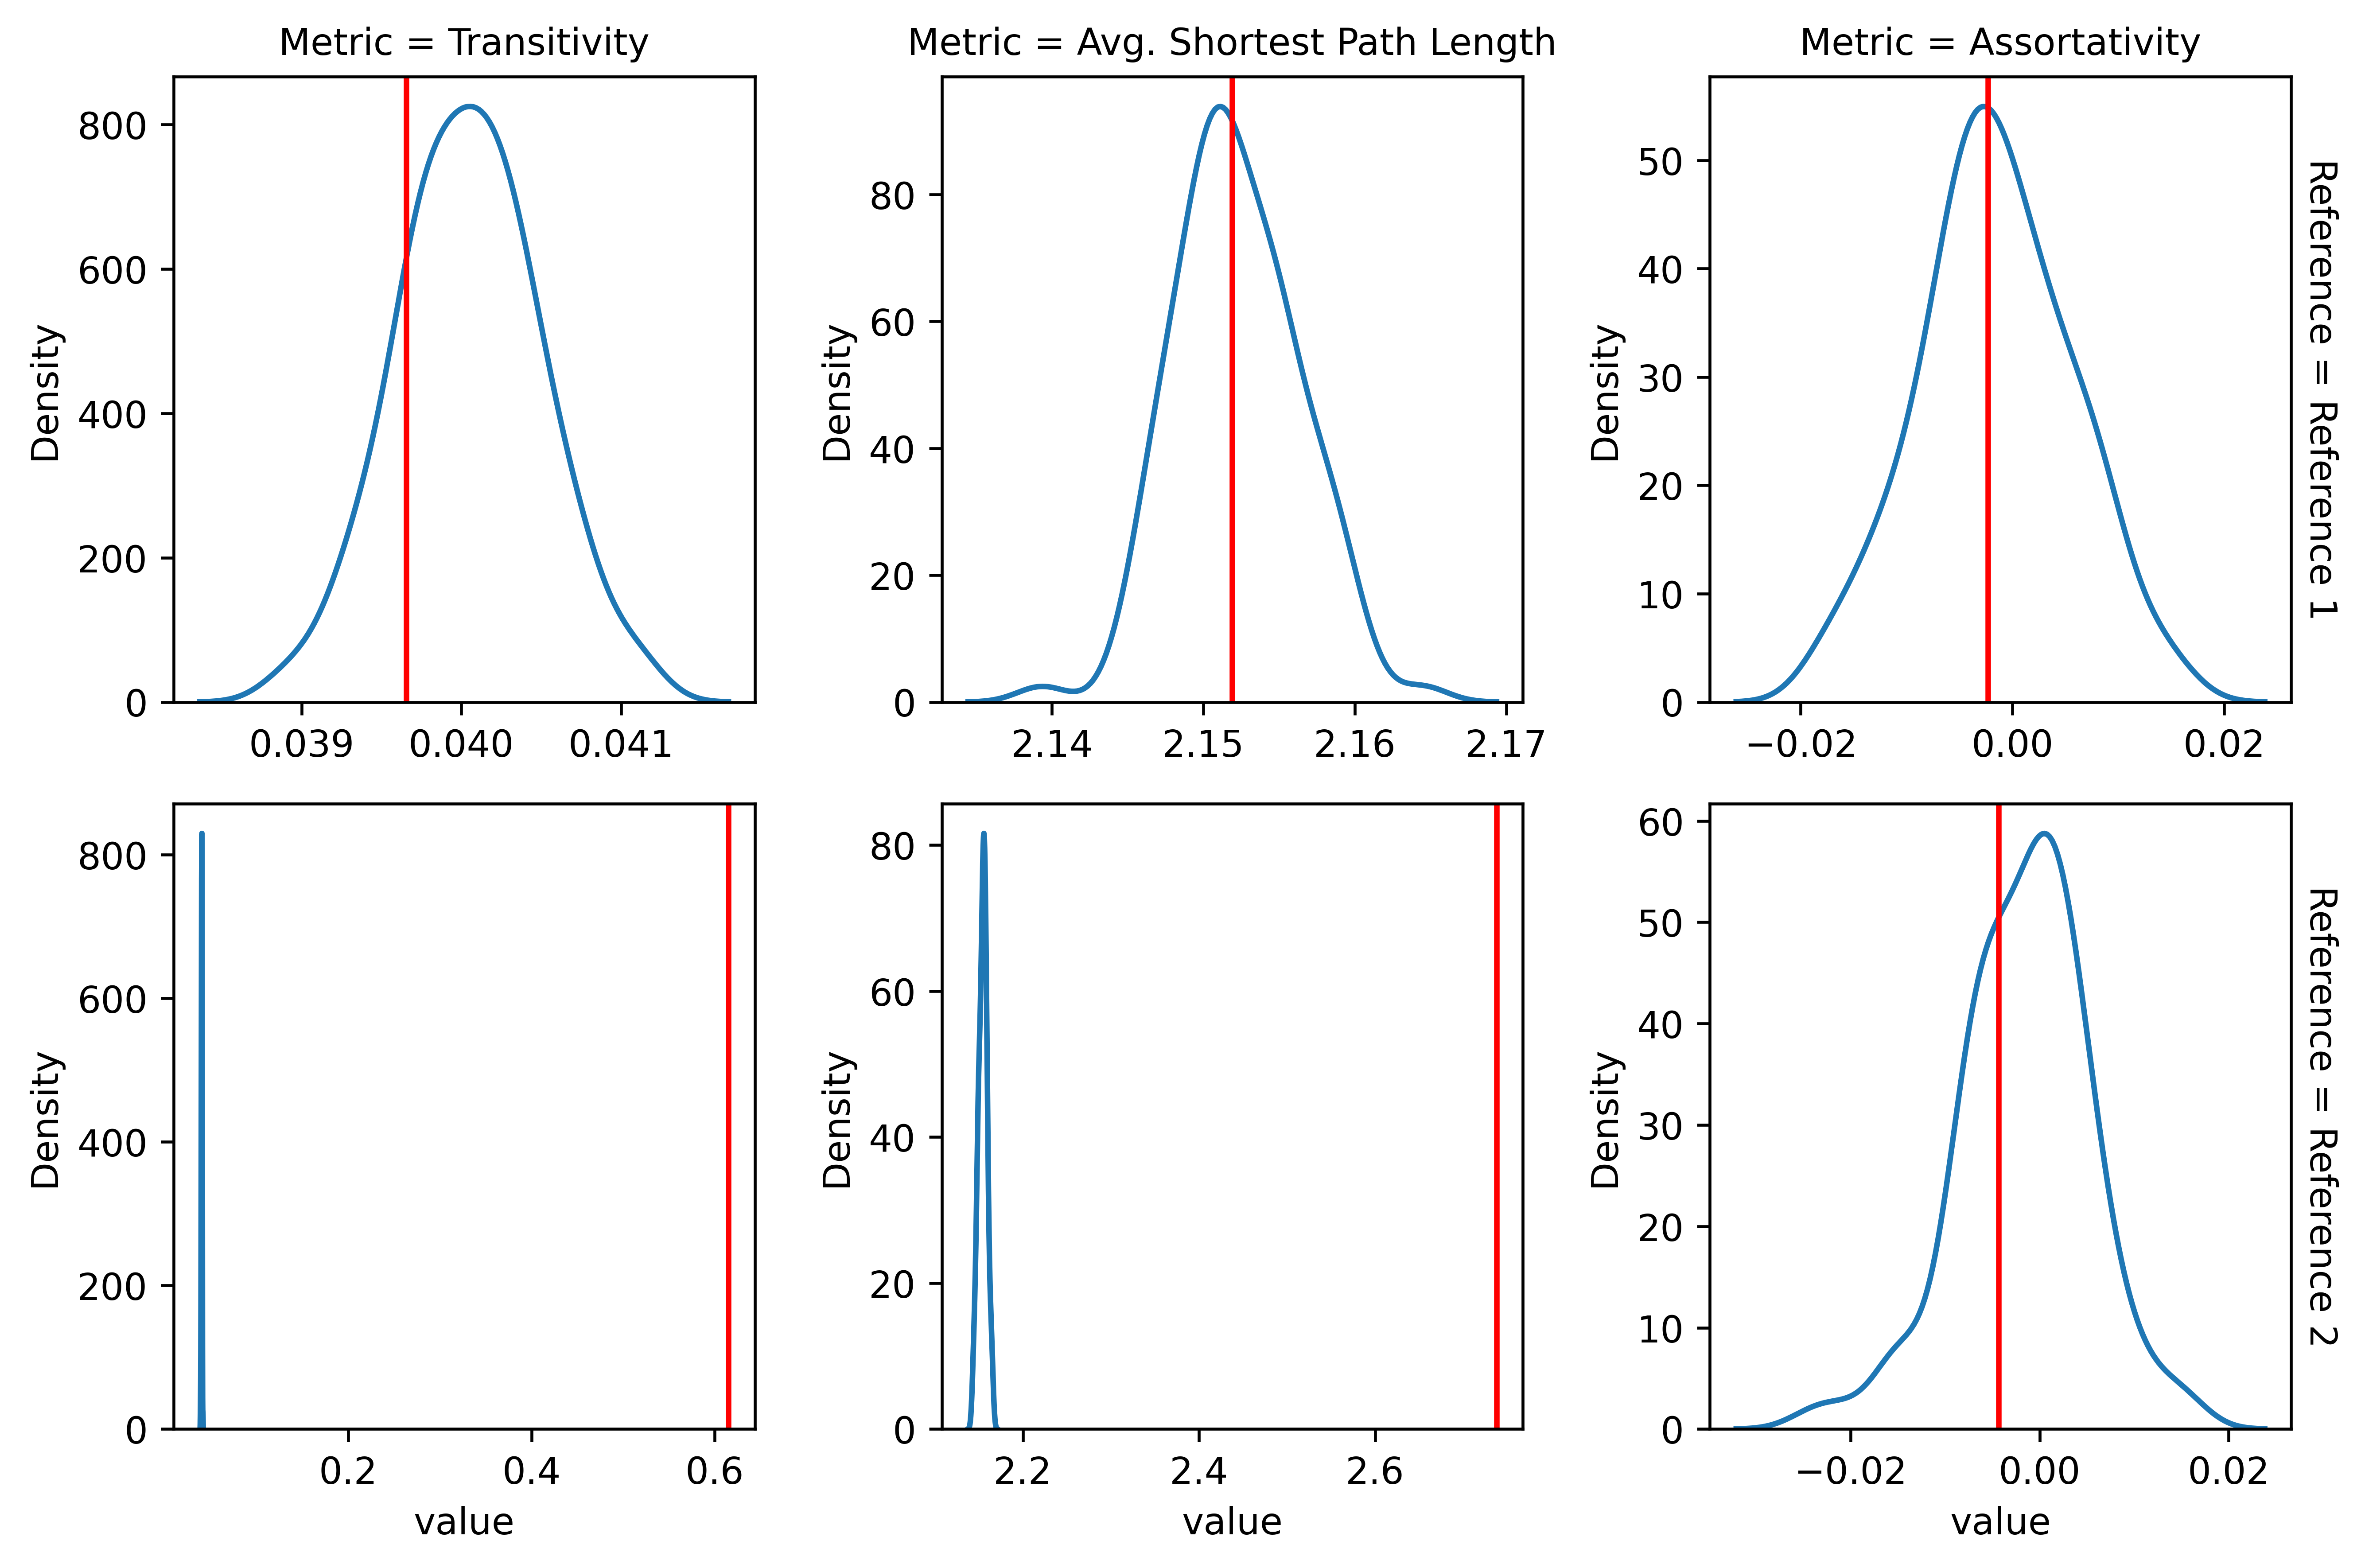

In [46]:
#print(df)
df2 = df.melt(id_vars=["Reference"], var_name="Metric")
#print(df2)
g = sns.FacetGrid(df2, col="Metric", row="Reference", sharex=False, sharey=False, despine=False, margin_titles=True)
g.map(sns.kdeplot, "value")
g.axes[0,0].axvline(x=nx.transitivity(G1), color='r')
g.axes[0,1].axvline(x=nx.average_shortest_path_length(G1), color='r')
g.axes[0,2].axvline(x=nx.degree_assortativity_coefficient(G1), color='r')
g.axes[1,0].axvline(x=nx.transitivity(G2), color='r')
g.axes[1,1].axvline(x=nx.average_shortest_path_length(G2), color='r')
g.axes[1,2].axvline(x=nx.degree_assortativity_coefficient(G2), color='r')
plt.show()

#### So, can we reject the null hypothesis? Are these graphs G(n,p)?

We performed a similar exercise in CNET5051 where we compared graphs to the configuration model or the Chung-Lu model to determine whether their attributes could be a result of the degree distribution or whether there was some manner of preferential attachment present.

Now we can get much more specific: could this graph have come from the BA model? The WS small world model? We can fit each model to the data to find the most likely parameters, then generate a distribution of plausible graphs from the tuned model, and compare the real data to features of the distribution to determine plausibility.

----

### Estimating Networks from Observations

Last class we introduced _link prediction,_ when your adjacency matrix represents a subset of edges of the true graph and you are trying to predict the missing edges. Today we consider a similar task: we observe a number of interactions and are estimating the underlying adjacency matrix based on those interactions.

As an example, consider a playground study: you watch children play over recess and try to estimate a friendship graph. Two children are more likely to interact if they are friends, but may occasionally interact with non-friends, and they don't always interact with friends, or may interact while you're not looking, so we may miss some interactions.

Formally, we are trying to estimate adjacency matrix $A$ using evidence matrix $E$. While $A_{ij} \in \{0,1\}$, $E_{ij} \in \mathbb{N}$.

#### The Standard Model

We typically assume all vertices are known without error. We make $N$ measurements of the connection status of every pair of nodes with observation errors. Therefore, $E_{ij} \in [0,N]$. We assume all edges are conditionally independent.

|             | True No Edge | True Edge |
| ----------- | ------------ | --------- |
| Observed No Edge     | True neg. $1-\beta$ | False neg. $1-\alpha$ |
| Observed Edge        | False pos. $\beta$ | True pos. $\alpha$ |

For now let's assume a simple graph with symmetric observations, $E_{ij} = E_{ji}$.

##### If there is an edge

$$P(E_{ij} | N, \alpha, A_{ij}=1) = \alpha^{E_{ij}} (1-\alpha)^{N-E_{ij}}$$

That is, the true positive observation rate to the power of our positive observations, times the false negative rate to the power of all our negative observations.

##### If there is not an edge

$$P(E_{ij} | N, \beta, A_{ij}=0) = \beta^{E_{ij}} (1-\beta)^{N-E_{ij}}$$

Or, the false positive rate to the power of our positive observations, times the true positive rate to the power of our negative observations.

##### All together now

$$P(E_{ij} | N, \alpha, \beta, A_{ij}) = \left[ \alpha^{E_{ij}} (1-\alpha)^{N-E_{ij}} \right] ^ {A_{ij}} \left[ \beta^{E_{ij}} (1-\beta)^{N-E_{ij}} \right] ^ {(1-A_{ij})}$$

##### Now generalize to all $ij$

$$P(E | N, \alpha, \beta, A) = \prod_{i<j} \left[ \alpha^{E_{ij}} (1-\alpha)^{N-E_{ij}} \right] ^ {A_{ij}} \left[ \beta^{E_{ij}} (1-\beta)^{N-E_{ij}} \right] ^ {(1-A_{ij})}$$

#### Your turn!

In this class's data folder is `data/observations.txt`, where every line describes two students we have observed interacting. Assume N=100, $\alpha=0.8$, $\beta=0.2$, and there are ten students. What is the most likely adjacency matrix?

In [123]:
# First load the observations into E_{ij}
evidence = np.zeros((10,10), dtype=int)
with open("data/observations.txt", "r") as f:
    lines = f.read().split("\n")[:-1]
    for observation in lines:
        (a,b) = list(map(int, observation.split(" ")))
        evidence[a,b] += 1
        evidence[b,a] += 1

Now estimate $A_{ij}$ from $E_{ij}$. What is the probability of seeing observations given $A_{ij}=1$? What if $A_{ij}=0$? Remember: $P(edge) = \frac{P(evidence|edge)}{P(evidence|edge) + P(evidence|noedge)}$

_Hint / warning: The probability of observing any particular number of interactions is extremely low, so you are likely to face floating point numeric stability issues. Working with the log-likelihood is much easier._

In [ ]:
A = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        #A[i,j] = ...

Let's examine our plausible adjacency matrix visually

In [ ]:
img = plt.imshow(A, cmap="plasma")
plt.colorbar(img)
plt.show()

Okay, so we're more confident that some edges exist than others. Now let's render plausible graphs. Use confidence thresholds of 0.3, 0.5, and 0.7, and plot graphs using the edges we are at least $c$ confident exist.

_Hint: re-use the graph layout from the first plot on each subsequent plot to keep vertices in the same place_

In [ ]:
fig, axs = plt.subplots(3,1, figsize=(10,6))
for graph_i,c in enumerate([0.5,0.7,0.9]):
    # make and plot a graph...

#### Reference Solution, do not look below

There are two worlds: one where $A_{ij}=1$ and one where $A_{ij}=0$. We can calculate the probability of observing $E_{ij}$ evidence in each world as:

$$p(E_{ij}) = \begin{cases} \alpha^{E_{ij}} (1-\alpha)^{N-E_{ij}} & A_{ij} \text{ (edge exists)} \\ \beta^{E_{ij}} (1-\beta)^{N-E_{ij}} & 1-A_{ij} \text{ (edge does not exist)}\end{cases}$$

We know that $P(edge) = \frac{P(evidence|edge)}{P(evidence|edge) + P(evidence|noedge)}$, so:

$$p(A_{ij}) = \frac{\alpha^{E_{ij}} (1-\alpha)^{N-E_{ij}}}{\alpha^{E_{ij}} (1-\alpha)^{N-E_{ij}} + \beta^{E_{ij}} (1-\beta)^{N-E_{ij}}}$$

In principle, this is sufficient. However, due to numeric instability with very small floating point numbers, we'll re-do this with the log-likelihood:

$$p(A_{ij}) = 1 - \frac{E_{ij} \log \alpha + A_{ij} (N-E_{ij}) \log (1-\alpha)}{E_{ij} \log \alpha + A_{ij} (N-E_{ij}) \log (1-\alpha) + (1-A_{ij}) E_{ij} \log \beta + (1-A_{ij}) (N-E_{ij}) \log (1-\beta)}$$

Remember that $\log$ of a small fraction yields a larger magnitude negative number, so we need to invert the probability by subtracting from one.

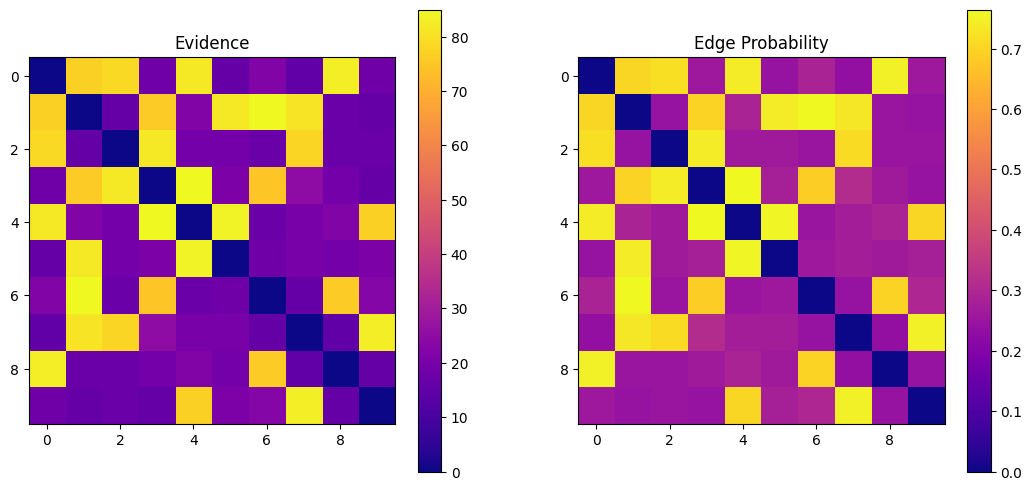

In [153]:
# First load the observations into E_{ij}
evidence = np.zeros((10,10), dtype=int)
with open("data/observations.txt", "r") as f:
    lines = f.read().split("\n")[:-1]
    for observation in lines:
        (a,b) = list(map(int, observation.split(" ")))
        evidence[a,b] += 1
        evidence[b,a] += 1

#print(evidence)
N = 100
alpha = 0.8
beta = 0.2
A = np.zeros((10,10))
for i in range(9):
    for j in range(i+1,10):
        E = evidence[i,j]
        p_edge_exists = (E * math.log(alpha) + (N-E) * math.log(1-alpha))
        p_edge_not_exists = (E * math.log(beta) + (N-E) * math.log(1-beta))
        p_edge = 1 - (p_edge_exists / (p_edge_exists + p_edge_not_exists))
        #print("%.4f, %.4f => %.4f" % (p_edge_exists, p_edge_not_exists, p_edge))
        A[i,j] = p_edge
        A[j,i] = A[i,j]

fig, axs = plt.subplots(1,2, figsize=(13,6), dpi=100)
img = axs[0].imshow(evidence, cmap="plasma")
fig.colorbar(img, ax=axs[0])
axs[0].set_title("Evidence")
img = axs[1].imshow(A, cmap="plasma")
fig.colorbar(img, ax=axs[1])
axs[1].set_title("Edge Probability")
plt.show()

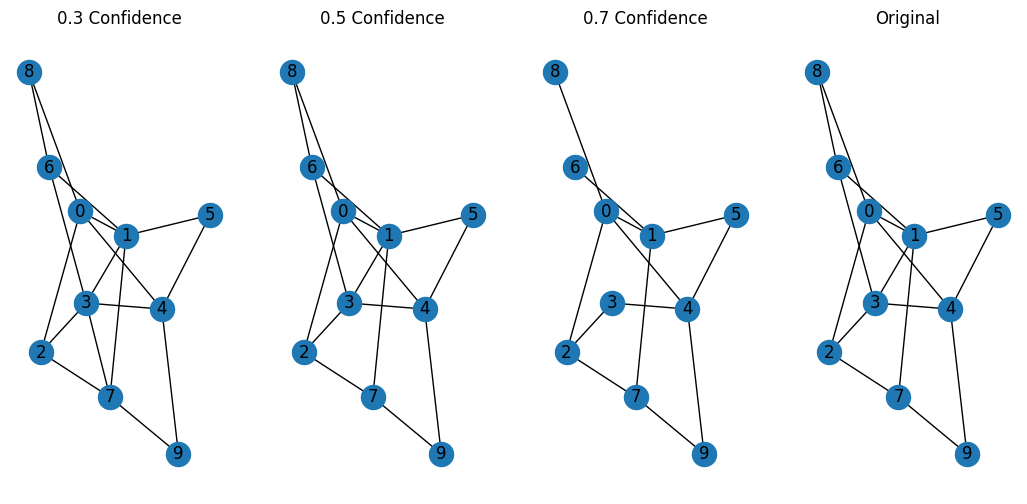

In [155]:
fig, axs = plt.subplots(1,4, figsize=(13,6), dpi=100)
pos = None
for graph_i,c in enumerate([0.3,0.5,0.7]):
    G = nx.empty_graph(10)
    for i in range(9):
        for j in range(i+1,10):
            if( A[i,j] >= c ):
                G.add_edge(i,j)
    if( not pos ):
        pos = nx.spring_layout(G)
    nx.draw(G, ax=axs[graph_i], pos=pos, with_labels=True)
    axs[graph_i].set_title("%.1f Confidence" % c)

# Plot the original graph for comparison
G = nx.read_adjlist("data/observation_cheat_code.txt")
rename = dict()
for n in range(10):
    rename[str(n)] = n
G = nx.relabel_nodes(G, rename)
nx.draw(G, ax=axs[3], pos=pos, with_labels=True)
axs[3].set_title("Original")
plt.show()

#### What if we don't know our observational parameters?

$$\hat{\alpha} = \operatorname*{argmax}_\alpha \log P(E | N, \alpha, \beta, A)$$

$$\log P(E | N, \alpha, \beta, A) = \sum_{i<j} \left( A_{ij} E_{ij} \log \alpha + A_{ij} (N-E_{ij}) \log (1-\alpha) \right) + \sum_{i<j}  \left( (1-A_{ij}) E_{ij} \log \beta + (1-A_{ij}) (N-E_{ij}) \log (1-\beta) \right)$$

To find max likelihood for $\alpha$ or $\beta$ derive w.r.t $\alpha$ or $\beta$ and set to zero.

#### Let's solve for $\alpha$

$$
\begin{align}
\frac{\partial}{\partial \alpha} \log P(E | N, \alpha, \beta, A) &= 0 && \text{Given} \\
\sum_{i<j} \frac{A_{ij}E_{ij}}{\alpha} - \sum_{i<j}\frac{A_{ij} (N-E_{ij})}{1-\alpha} &= 0 && \text{Sub. in derivative of log P} \\
\frac{1}{\alpha} \sum_{i<j} A_{ij}E_{ij} - \frac{1}{1-\alpha}\sum_{i<j} A_{ij} (N-E_{ij}) &= 0 && \text{Factor out $\alpha$ term} \\
\frac{\sum_{i<j} A_{ij} E_{ij}}{\sum_{i<j} A_{ij}N} &= \alpha && \text{Solve (with some inductive reasoning)}
\end{align}
$$

#### That Inductive Reasoning Step (Optional)

$$
\begin{align}
\frac{1}{\alpha} \sum_{i<j} A_{ij}E_{ij} &= \frac{1}{1-\alpha}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Given} \\
\end{align}
$$

We need the left term to equal the right. Let's start by eliminating the left summation. We need the _numerator_ of $\alpha$ to equal the summation so that the denominator of $\alpha^{-1}$ will match. So let $\alpha = \frac{\sum_{i<j} A_{ij}E_{ij}}{X}$:

$$
\begin{align}
\frac{X}{\sum_{i<j} A_{ij}E_{ij}} \sum_{i<j} A_{ij}E_{ij} &= \frac{1}{1-\frac{\sum_{i<j} A_{ij}E_{ij}}{X}}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Def. of $\alpha$} \\
X &= \frac{1}{1-\frac{\sum_{i<j} A_{ij}E_{ij}}{X}}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Simplify} \\
\end{align}
$$

Let's make that expression simpler by trying to cancel out the $A_{ij}$ in $\alpha$'s numerator. Let $X = \sum_{i<j}A_{ij}Y$:

$$
\begin{align}
\sum_{i<j}A_{ij}Y &= \frac{1}{1-\frac{\sum_{i<j} A_{ij}E_{ij}}{\sum_{i<j}A_{ij}Y}}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Def. of $X$} \\
\sum_{i<j}A_{ij}Y &= \frac{1}{1-\frac{\sum_{i<j} E_{ij}}{\sum_{i<j}Y}}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Cross cancel} \\
\end{align}
$$

That $1-\alpha$ is getting frustrating, let's move it into the fraction and summation:

$$
\begin{align}
\sum_{i<j}A_{ij}Y &= \frac{1}{\frac{\sum_{i<j} Y - E_{ij}}{\sum_{i<j}Y}}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Replace $1$ with $\frac{\sum_{i<j}Y}{\sum_{i<j}Y}$} \\
\sum_{i<j}A_{ij}Y &= \frac{\sum_{i<j}Y}{\sum_{i<j} Y - E_{ij}}\sum_{i<j} A_{ij} (N-E_{ij}) && \text{Flip the fraction of a fraction} \\
\sum_{i<j}A_{ij}Y &= \sum_{i<j} \frac{A_{ij} (N-E_{ij})Y}{Y - E_{ij}} && \text{Combine summations} \\
\sum_{i<j}A_{ij}N &= \sum_{i<j} \frac{A_{ij} (N-E_{ij})N}{N - E_{ij}} && \text{Let $Y=N$} \\
\sum_{i<j}A_{ij}N &= \sum_{i<j} A_{ij} N && \text{Cross cancel} \\
\end{align}
$$

Success! Working backwards, we said $\alpha$ was a fraction where the numerator was $\sum_{i<j} A_{ij}E_{ij}$ and the denominator $X = \sum_{i<j}A_{ij}Y$ where $Y = N$ for a complete denominator of $\sum_{i<j}A_{ij}N$ and finally $\alpha = \frac{\sum_{i<j} A_{ij}E_{ij}}{\sum_{i<j}A_{ij}N}$. Woohoo!

#### Conclusion

We can solve for parameters ($\alpha$, $\beta$), or the adjacency matrix ($A$), or the observations ($E$) using maximum likelihood estimation _so long as_ we know two of the three. This can work great in model-land for reverse-engineering a model or calibrating a model to data or producing plausible observations from a model or using a tuned model + observations to predict a network.

Unfortunately in the real world we often do _not_ know two out of three. We frequently have observations, but know neither the true adjacency matrix nor the appropriate model parameters. If the partial derivitive for parameters $\alpha$ and $\beta$ are in terms of an unknown $A_{ij}$ then how can we solve for both at once?

_cue maniacal laughter..._

------

### Expectation Maximization

The EM algorithm comes from _Maximum Likelihood from Incomplete Data Via the EM Algorithm_ (Dempster, Laird, and Rubin, 1977), 77k (!!) citations.

It's a little cursed! We will come to embrace it. The intuition: set some initial guesses for our parameters $\theta$ (shorthand for the set of all model parameters, $\theta = \{\alpha,\beta\}$ in the above example), then solve for $\hat{A}$ based on the observations and tuned model, then plug in $\hat{A}$ to re-estimate parameters $\theta$, then use the new $\theta$ and observations to re-solve for $\hat{A}$, and repeat until we converge.

The hard part: $P(E | \theta, A)$ is a piecewise function, it assumes that $A_{ij}$ is zero or one, and does not behave well if we try to feed it _likelihoods._ Instead we will operate over the distribution of all possible adjacency matrices, times the probability of any given adjacency matrix occuring from our evidence:

$$P(\theta | E) = \sum_{\hat{A} \in \underline{\underline{A}}} p(\theta, \hat{A} | E)$$

The math here gets fairly complicated, so we will stop with the intuition behind EM for today.


__________
## Next time...
The Stochastic Block Model
_______

## References and further resources:

1. Class Webpages
    - Github: https://github.com/network-science-data-and-models/cnet5052_sp26
    - Syllabus and course details: https://brennanklein.com/cnet5052-spring26
2. Think Bayes 2 for an interactive notebook on Bayesian stats using computational methods: https://allendowney.github.io/ThinkBayes2/
3. The original EM paper: https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1977.tb01600.x